In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sqlite3

In [2]:
input_file="20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv"
date_column_name = 'reporting_time'

# Loading of dataset
df_origin = pd.read_csv(input_file, parse_dates=['reporting_time'])

#delete discontinuing products
df_continue = df_origin[df_origin['reporting_time']=='2023-02-01T00:00:00.000Z'].copy()
df_continue_origin = df_origin[df_origin['product_name'].isin(df_continue['product_name'])].copy()

df_continue_origin['reporting_time'] = pd.to_datetime(df_continue_origin['reporting_time'], utc=True)
df_continue_origin['reporting_time'] = df_continue_origin['reporting_time'].dt.tz_localize(None)
df_continue_origin.set_index('reporting_time', inplace=True)
df_continue_origin['product_application'] = df_continue_origin['product_application'].fillna('nan')
sub_df = df_continue_origin

In [3]:
all_app_list = ['product_application', list(sub_df.product_application.unique())]
all_fam_list = ['product_main_family', list(sub_df.product_main_family.unique())]
all_mkt_list = ['product_marketing_name', list(sub_df.product_marketing_name.unique())]
all_bsc_list = ['product_basic_type', list(sub_df.product_basic_type.unique())]

In [4]:
conn = sqlite3.connect('metadata.db')
cur = conn.cursor()


def add_to_db(df, cat_list):
    for name in cat_list[1]:
        tab_name = cat_list[0] + "_" + name
        cur.execute(f'CREATE TABLE IF NOT EXISTS {tab_name} (demand INT(255))')
        series_pd = create_table(df=df, category=cat_list[0], sub_category=name, target='demand')
        series_pd.to_sql(tab_name, conn, if_exists='replace', index=True)

def create_table(df, category, sub_category, target):
    sub_set = df[df[category]==sub_category].copy()
    agg_series =  sub_set[target].resample('M').mean()
    return agg_series

cats = [all_app_list, all_fam_list, all_mkt_list, all_bsc_list]

for cat in cats:
    add_to_db(df=sub_df, cat_list=cat)


conn.commit()
cur.close()
conn.close()

In [5]:
conn = sqlite3.connect('metadata.db')
db_tables = pd.read_sql("""select * from sqlite_master where type="table" and name !='sqlite_sequence';""", con=conn)

In [6]:
tables = {}
db_tables.name
for table_name in db_tables.name:
    table = pd.read_sql("select * from " + table_name, con=conn)
    table = table.set_index('reporting_time')
    tables[table_name] = table

In [7]:
input_dict = {'product_application': 'blau', 'product_main_family':'K', 'product_marketing_name':'maus', 'product_basic_type': 'BT66'}

new_prod_df = pd.DataFrame()
for key, value in input_dict.items():
    # print(key, value)
    tab = tables[key+'_'+value].rename({'demand':f"{value}_demand"}, axis = 1)
    new_prod_df = pd.concat((new_prod_df, tab), axis=1)

In [8]:
conn.close()

LSTM

Get sample of 100

In [19]:
import random
no_months = 30
m_50_df = df_continue_origin[df_continue_origin.groupby('product_name').product_name.transform('count')>=no_months].copy()
rand_prods = random.choices(list(m_50_df.product_name.unique()), k = 100)

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

results_df = pd.DataFrame()
smape_list = []

def smape_loss(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    numerator = tf.reduce_sum(tf.abs(y_true - y_pred))
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / denominator


for prod in rand_prods:
    prod_features= sub_df[sub_df['product_name']==prod].max()
    input_dict = {'product_application': prod_features['product_application'], 'product_main_family':prod_features['product_main_family'],
                  'product_marketing_name':prod_features['product_marketing_name'], 'product_basic_type': prod_features['product_basic_type']}
    
    new_prod_df = pd.DataFrame()
    for key, value in input_dict.items():
        # print(key, value)
        tab = tables[key+'_'+value].rename({'demand':f"{value}_demand"}, axis = 1)
        new_prod_df = pd.concat((new_prod_df, tab), axis=1)

    new_prod_df['mean_demand'] = new_prod_df.mean(axis=1, skipna=True)

    # Load your demand data into a DataFrame
    df = new_prod_df

    # Preprocess the data
    scaler = MinMaxScaler()
    df['ScaledDemand'] = scaler.fit_transform(df['mean_demand'].values.reshape(-1, 1))

    # Split the data into training and testing sets
    train_data, test_data = train_test_split(df['ScaledDemand'].values, test_size=0.2, shuffle=False)

    # Define the number of time steps to consider for each input sample
    timesteps = 5

    # Prepare the training data
    X_train = []
    y_train = []
    for i in range(timesteps, len(train_data)):
        X_train.append(train_data[i - timesteps:i])
        y_train.append(train_data[i])
    

    # Convert the training data to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(X_train.shape[0], X_train.shape[1])


    # Reshape the training data to match LSTM input shape (samples, timesteps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print('shaped')

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(timesteps, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss=smape_loss)
    print('built')

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Prepare the test data
    X_test = []
    y_test = []
    for i in range(timesteps, len(test_data)):
        X_test.append(test_data[i - timesteps:i])
        y_test.append(test_data[i])

    # Convert the test data to numpy arrays
    X_test, y_test = np.array(X_test), np.array(y_test)
    # print(X_test.shape)

    # Reshape the test data to match LSTM input shape (samples, timesteps, features)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Make predictions on the test data
    predictions = model.predict(X_test)

    # Inverse transform the predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate SMAPE
    actual = sub_df[sub_df['product_name']==prod]['demand'][-18:].reset_index()
    smape = 1- smape_loss(actual['demand'], predictions)
    smape_list.append(smape)
    print(f'smape: {smape}')

results_df = pd.DataFrame({'product_name':rand_prods, 'accuracy':smape_list})

38 5
shaped
built
Epoch 1/10
2/2 [==============================] - 2s 6ms/step - loss: 1.3270
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 1.0375
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 0.8552
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.6695
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 0.5783
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.4896
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.4192
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 0.3575
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.3179
Epoch 10/10
1/1 [==============================] - 0s 320ms/step
smape: 0.0007402300834655762
38 5
shaped
built
Epoch 1/10
2/2 [==============================] - 2s 7ms/step - loss: 1.5293
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 1.2394
Epoch 3/10
2/2 [=======

<function matplotlib.pyplot.show(close=None, block=None)>

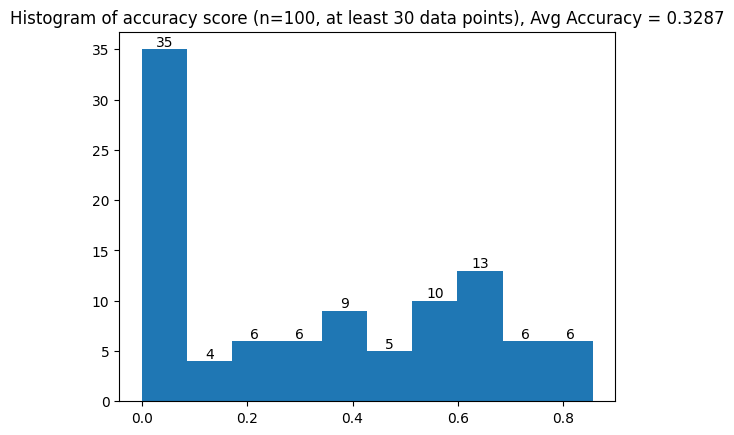

In [22]:
results_df['accuracy'] = results_df['accuracy'].apply(lambda x:float(x))
counts, edges, bars = plt.hist(results_df['accuracy'])
plt.bar_label(container=bars)
plt.title(f'Histogram of accuracy score (n=100, at least 30 data points), Avg Accuracy = {round(results_df["accuracy"].mean(), 4)}')
plt.show

In [134]:
results_df.to_csv('cold_start.csv')